In [31]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground
from photutils.utils import calc_total_error

In [32]:
#data path
#dpath='E:\Documents\SofiaLegacyProgram\CAL_files\CAL_R'
dpath='C:/Users/mhankins1/Documents/SofiaLegacyProgram/SOFIA_Cycle7_Data/SgrCandNearby'

#file name
fname='F0595_FO_IMA_0701895_FORF253_CAL_0259-0282_FIELD_5.fits'

#Name of field
field='Field5'

#wavelength of data
wavelength=25.2

In [33]:
#change directory to data location
os.chdir(dpath)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(fname)
header=hdu[0].header
ims=hdu[0].data
#np.shape(ims)
data=ims[0]
varmap=ims[1]
tmap=ims[2]
#wcsmap = WCS(header)
hdu.close()

#hack to make SOFIA wcs header work correctly with astropy.wcs
hdu[0].header['NAXIS']=2
wcsmap=WCS(hdu[0].header)

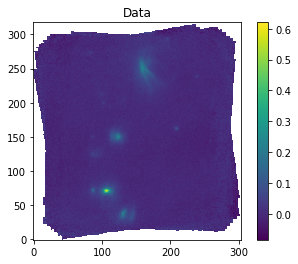

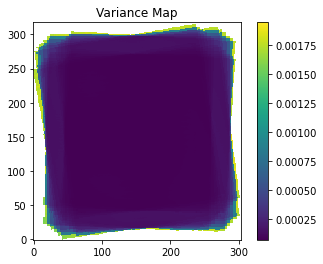

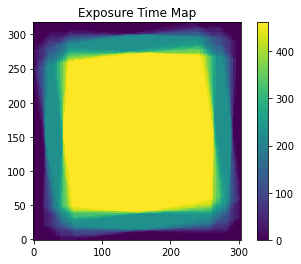

In [34]:
#take a quick look at the maps that were loaded in 
plt.figure()
plt.title('Data')
plt.imshow(data,origin='lower',interpolation='none')
plt.colorbar()
#plt.clim(0.0,0.1)
plt.show()

plt.figure()
plt.title('Variance Map')
plt.imshow(varmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Exposure Time Map')
plt.imshow(tmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

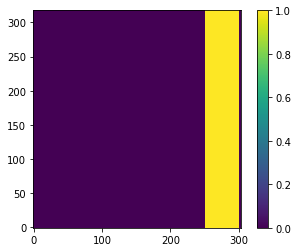

In [35]:
#create mask for edges of field where less integration time was collected
tmapnorm=tmap/np.max(tmap) #normalize the exposure time map
mask=np.where(tmapnorm<0.5,tmapnorm,0).astype('bool') #create mask for any locations with less than 50% of max exposure time -Can be modified as needed

#additional series of masks that can be applied when searching for sources in the segmentation map
mask2=np.zeros(np.shape(mask))  #mask 2 is applied to the first segmentation map instance for source detection
mask2[0:330,250:300]=1
mask3=np.zeros(np.shape(mask))  #mask 3 is applied to the deblended segmentation map for source detection - this may or may not be needed if the first 2 masks work ok
mask3[0:330,0:70]=1

#plot any of the masks to verify they are configured as needed
plt.figure()
plt.imshow(mask2,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [36]:
#create background model for image using median method
bkg_estimator = MedianBackground()
bkg_data = Background2D(data,(16, 16), filter_size=(3, 3),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms
bkg=bkg_data.background 

#create background subtracted image
data_bkgsub = data - bkg

#set detection threshold for source finding based on modeled background rms
threshold = 3.0*bkg_rms

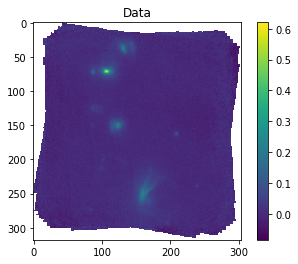

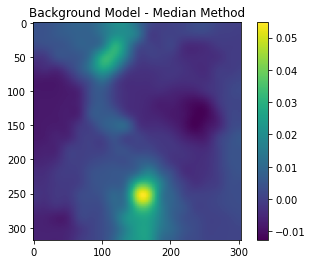

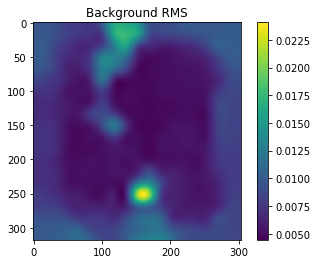

In [37]:
#take a look at data and bakground model images
plt.figure()
plt.title('Data')
plt.imshow(data,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background Model - Median Method')
plt.imshow(bkg,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background RMS')
plt.imshow(bkg_rms,interpolation='none')
plt.colorbar()
plt.show()

In [38]:
#do source detection. A 3x3 FWHM gaussian is used to smooth image prior to detection
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data_bkgsub, threshold, mask=mask, npixels=5, filter_kernel=kernel)

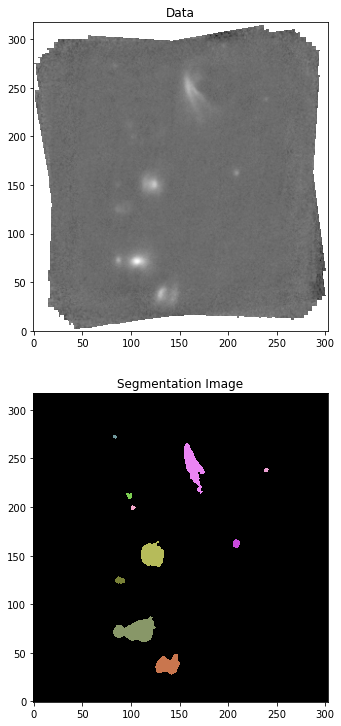

In [39]:
#removed labels that exist in masked region (mask2)
segm.remove_masked_labels(mask2.astype('bool'))

#make plot of segmentation image to show detected sources
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data_bkgsub, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Segmentation Image')
plt.show()

In [40]:
#now lets look at building a catalog and associated table from the seg map
cat = SourceCatalog(data_bkgsub, segm,background=bkg,wcs=wcsmap) #can also take in error and bkg measurements - this is done later

#specify the columns that we want for our table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl = cat.to_table(columns)

#display table below
tbl

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,136.01802361040205,37.28695695655949,"266.2698400255177,-29.195799102743536",-0.0075982513428169245,0.01599472773170748,5.7740967111464006,361.0,6.422699546363186,4.152028016058178,4.799517789619829,0.02447817079239433,-0.005630399120471854,0.05777049728481909,0.7629466051572328,0.35353849482041577,1.546882516573364,12.73459227211453,21.70087594492653,nan,0.7158460417490344,26.11748603677495,nan
2,105.98716154272573,71.90735579104526,"266.2771783507916,-29.18841315433132",-0.00342008271916008,0.016663879791997342,11.314774378766195,679.0,8.616800825301599,4.168890055950024,3.03243742708933,0.01359148158240433,-0.004656237908406822,0.05741524365695797,0.8751733385630137,0.5161905049831406,2.0669292568661817,15.938922701444127,70.25320679438789,nan,1.3586057483419933,61.47216648645244,nan
3,88.5486546722902,124.5488026197025,"266.2814382661611,-29.177182642532923",-0.0012460201479262095,0.005647129226364597,0.3727105289400634,66.0,2.7028742483211388,1.8256747370549247,-13.919346976883787,0.14632302869659877,0.07618349422001398,0.29058165388252366,0.7373995783038069,0.32454321980057976,1.4804796240327358,5.431069025143904,5.3946689812313915,nan,2.6614300055116678,2.1114772193430844,nan
4,121.80358723541922,150.60946365378916,"266.27331265296647,-29.171623560505438",-0.0043280873083988945,0.008450474316964635,4.081579095093918,483.0,5.500199645140461,4.922875172076749,-35.90671821250241,0.03587843871741396,0.007797682875238806,0.03844016025006406,0.4459944535381313,0.10496427590111035,1.117273839551809,12.291043634546321,40.963367058398504,nan,1.3799994379097387,35.05927320908158,nan
5,208.41638433682664,162.60885684816262,"266.25215162767114,-29.169062757110535",0.010113798393226466,-0.004911119064399497,-0.2995782629283693,61.0,2.027186288050507,1.7338568088947073,84.89451948035084,0.3319321112455416,-0.015830436406072197,0.24404671605582415,0.5181295366843096,0.14469784098524419,1.169177453207794,4.441737349067447,3.272148660070302,nan,1.896308157696814,2.3447741144033696,nan
6,102.37193944358322,199.63835554171152,"266.27805928055614,-29.1611638162659",-0.0053961250951613405,0.002718275304100704,0.046210680169711964,17.0,1.1997505470438228,1.0822842270685475,38.23509109758702,0.7556304627973571,-0.1545781985549729,0.792826497635365,0.4315457600327005,0.09790895304420699,1.108535555667703,2.690447868214032,1.46869041378259,nan,3.14737653710069,0.36470128128891144,nan
7,98.91043936827491,211.6769738222782,"266.27890465984655,-29.158595516225645",-0.0055045106107377145,0.004163666027988126,0.11658264878366752,28.0,1.6926954947544066,1.3537622802797604,-53.49911837564578,0.47607518826810336,0.18804734239101203,0.4185896740588898,0.6003103186968997,0.20023283309076334,1.2503639076164865,3.609060515045427,2.1450192682470437,nan,2.9823315974438818,0.5764887147101326,nan
8,162.6777543501715,244.87480817102036,"266.26332722881,-29.15151359556276",-0.009182844587327313,0.03979544455618178,19.619154166197617,493.0,10.561604281362248,3.399003439815438,-70.34632689392473,0.07777877522104781,0.04915243632004542,0.01774193975403464,0.9467986832397346,0.678173566319507,3.1072649582066125,18.47451321487557,66.46543376236866,nan,2.107252174263192,38.17645668261663,nan


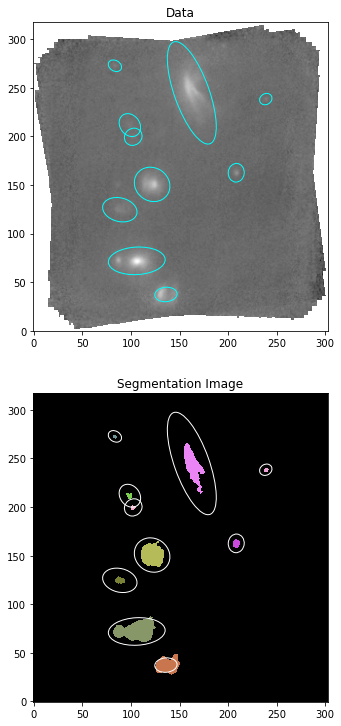

In [41]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in cat.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

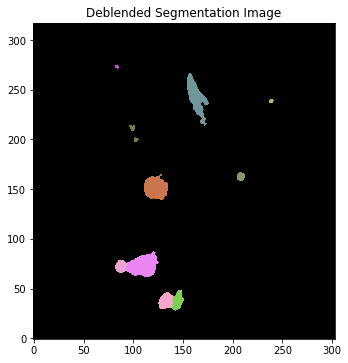

In [42]:
#lets take a look at deblending sources
segm_deblend = deblend_sources(data_bkgsub, segm, npixels=5,filter_kernel=kernel, nlevels=64,contrast=0.001)

#remove any sources that should be masked (mask3)
segm_deblend.remove_masked_labels(mask3.astype('bool'))

#plot the deblended image
plt.figure(figsize=(5.4, 8.5))
plt.imshow(segm_deblend, origin='lower', cmap=cmap, interpolation='nearest')
plt.title('Deblended Segmentation Image')
plt.show()

In [43]:
#now lets look at building a catalog and table from the deblended seg map
catde = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,wcs=wcsmap)

#define which columns we want to have in the table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl_deblend = catde.to_table(columns)

#display table
tbl_deblend

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,88.5486546722902,124.5488026197025,"266.2814382661611,-29.177182642532923",-0.0012460201479262095,0.005647129226364597,0.3727105289400634,66.0,2.7028742483211388,1.8256747370549247,-13.919346976883787,0.14632302869659877,0.07618349422001398,0.29058165388252366,0.7373995783038069,0.32454321980057976,1.4804796240327358,5.431069025143904,5.3946689812313915,nan,2.6614300055116678,2.1114772193430844,nan
2,121.80358723541922,150.60946365378916,"266.27331265296647,-29.171623560505438",-0.0043280873083988945,0.008450474316964635,4.081579095093918,483.0,5.500199645140461,4.922875172076749,-35.90671821250241,0.03587843871741396,0.007797682875238806,0.03844016025006406,0.4459944535381313,0.10496427590111035,1.117273839551809,12.291043634546321,40.963367058398504,nan,1.3799994379097387,35.05927320908158,nan
3,208.41638433682664,162.60885684816262,"266.25215162767114,-29.169062757110535",0.010113798393226466,-0.004911119064399497,-0.2995782629283693,61.0,2.027186288050507,1.7338568088947073,84.89451948035084,0.3319321112455416,-0.015830436406072197,0.24404671605582415,0.5181295366843096,0.14469784098524419,1.169177453207794,4.441737349067447,3.272148660070302,nan,1.896308157696814,2.3447741144033696,nan
4,102.37193944358322,199.63835554171152,"266.27805928055614,-29.1611638162659",-0.0053961250951613405,0.002718275304100704,0.046210680169711964,17.0,1.1997505470438228,1.0822842270685475,38.23509109758702,0.7556304627973571,-0.1545781985549729,0.792826497635365,0.4315457600327005,0.09790895304420699,1.108535555667703,2.690447868214032,1.46869041378259,nan,3.14737653710069,0.36470128128891144,nan
5,98.91043936827491,211.6769738222782,"266.27890465984655,-29.158595516225645",-0.0055045106107377145,0.004163666027988126,0.11658264878366752,28.0,1.6926954947544066,1.3537622802797604,-53.49911837564578,0.47607518826810336,0.18804734239101203,0.4185896740588898,0.6003103186968997,0.20023283309076334,1.2503639076164865,3.609060515045427,2.1450192682470437,nan,2.9823315974438818,0.5764887147101326,nan
6,238.83026331355106,238.43157934482684,"266.2447247984892,-29.152886128553426",-0.0020786168509627657,-0.0021357996241410148,-0.034172793986256236,16.0,1.120643020724096,0.9424249263704656,30.04658269507575,0.8789209822381434,-0.2857424721690957,1.0432755499746085,0.5410848484231502,0.15903199418355007,1.1891058792767681,2.4381233623427874,0.8428270556070364,nan,2.364068117558712,0.43704211073553095,nan
7,83.49612202741736,272.7736863455552,"266.28266846520887,-29.145561214126232",-0.00047686887077507404,0.002258163222472994,0.027097958669675928,12.0,1.0493627432187054,0.7846862604641084,-30.72438984135987,1.095014473334947,0.6288837791099093,1.4371987949988454,0.6639532547336483,0.25222591945922923,1.3373023029587037,2.1817980810465376,0.9591200017275857,nan,2.7674601219235897,0.3269788440608844,nan
8,132.0524113438249,37.417882019855725,"266.27080914071945,-29.195771160128547",-0.007596853610163358,0.021467084592758846,4.207548580180734,196.0,3.9800087851941286,3.0885739848469957,65.28930854119325,0.09754231608092372,-0.03167187010187919,0.07041673702202833,0.6307059605207971,0.22397809865730045,1.2886234245061459,8.3885418341701,24.34919965354463,nan,1.734472620270997,17.460385979104906,nan


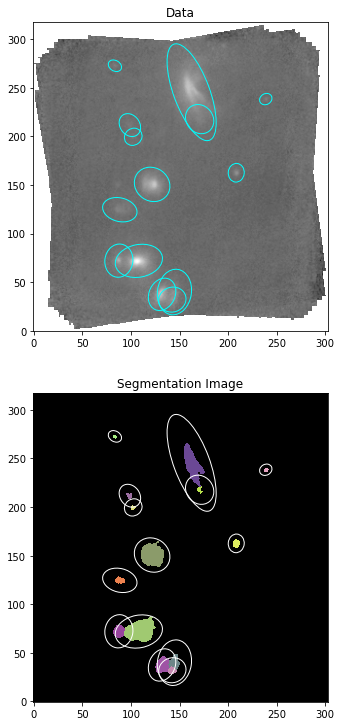

In [44]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm_deblend.make_cmap(seed=123)
ax2.imshow(segm_deblend, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in catde.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

In [45]:
#what if we wanted to include errors? - Not completely sure this is implemented correctly for our observations, but we'll use it for now...
calfactor = header['CALFCTR'] # units are (Me/sec/Jy)
gainfactor=tmap*calfactor*1e6 #gain in electrons/Jy
#errormap=calc_total_error(data,bkg,gainfactor) #use the varmap instead. Its probably more appropriate for our data type. 

#now lets look at building a catalog from the seg map
catwerr = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,error=errormap,wcs=wcsmap)
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','background','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']#,'kron_aperture']
tbl2 = catwerr.to_table(columns)

In [46]:
#calculate statistics for background cutouts in table
segbkg_median=[]
segbkg_mean=[]
segbkg_std=[]

#loop through each cutout and use sigma_cliped_stats to get mean, median, and std
for i in range (0,len(tbl2['background'])):
    bkgdata=tbl2['background'][i]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(bkgdata)
    segbkg_median.append(median_sigclip)
    segbkg_mean.append(meansc)
    segbkg_std.append(stdsc)

#add the above calculated information to our table
tbl2['segbkg_mean_sc']=segbkg_mean
tbl2['segbkg_median_sc']=segbkg_median
tbl2['segbkg_std_sc']=segbkg_std  

#remove the 2d background array to tidy up the table
tbl2.remove_column('background')

In [47]:
#calculate noise stats
#sky noise from background
skynoise=np.sqrt(tbl2['segbkg_median_sc']*tbl2['area']/u.pix**2)
#replace any nan values with zero
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#shot noise from the source
sourcenoise=tbl2['segment_flux']

#thermal noise from camera (from error map)
thermalnoise=tbl2['segment_fluxerr']

#total noise
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #includes all noise sources
totalnoise=np.sqrt(thermalnoise+skynoise) #no shot noise -> For some reason this seems to work much better for the apertures. Need to think about why this is a bit more...

#calculate SNR for the segments
tbl2['segmentSNR']=tbl2['segment_flux']/ totalnoise 

#display table
tbl2

C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64
1,88.5486546722902,124.5488026197025,"266.2814382661611,-29.177182642532923",-0.0012460201479262095,0.005647129226364597,0.3727105289400634,66.0,2.7028742483211388,1.8256747370549247,-13.919346976883787,0.14632302869659877,0.07618349422001398,0.29058165388252366,0.7373995783038069,0.32454321980057976,1.4804796240327358,5.431069025143904,5.3946689812313915,0.22905704564657148,2.6614300055116678,2.1114772193430844,0.07105882,0.005673804110468762,0.005903587798025578,0.0007215142624711953,3.110852089658853
2,121.80358723541922,150.60946365378916,"266.27331265296647,-29.171623560505438",-0.0043280873083988945,0.008450474316964635,4.081579095093918,483.0,5.500199645140461,4.922875172076749,-35.90671821250241,0.03587843871741396,0.007797682875238806,0.03844016025006406,0.4459944535381313,0.10496427590111035,1.117273839551809,12.291043634546321,40.963367058398504,0.2728794214766754,1.3799994379097387,35.05927320908158,0.1883232,0.007854968374175219,0.008156032935515733,0.0015791576411173824,17.256373189343893
3,208.41638433682664,162.60885684816262,"266.25215162767114,-29.169062757110535",0.010113798393226466,-0.004911119064399497,-0.2995782629283693,61.0,2.027186288050507,1.7338568088947073,84.89451948035084,0.3319321112455416,-0.015830436406072197,0.24404671605582415,0.5181295366843096,0.14469784098524419,1.169177453207794,4.441737349067447,3.272148660070302,0.13910873990982683,1.896308157696814,2.3447741144033696,0.06896897,-0.004989864398964471,-0.004977315504660779,0.0007081644055886727,8.928410542127502
4,102.37193944358322,199.63835554171152,"266.27805928055614,-29.1611638162659",-0.0053961250951613405,0.002718275304100704,0.046210680169711964,17.0,1.1997505470438228,1.0822842270685475,38.23509109758702,0.7556304627973571,-0.1545781985549729,0.792826497635365,0.4315457600327005,0.09790895304420699,1.108535555667703,2.690447868214032,1.46869041378259,0.1400605064638681,3.14737653710069,0.36470128128891144,0.03634117,0.002786854811433196,0.002788213775074141,0.00023879233673248647,1.260284865912015
5,98.91043936827491,211.6769738222782,"266.27890465984655,-29.158595516225645",-0.0055045106107377145,0.004163666027988126,0.11658264878366752,28.0,1.6926954947544066,1.3537622802797604,-53.49911837564578,0.47607518826810336,0.18804734239101203,0.4185896740588898,0.6003103186968997,0.20023283309076334,1.2503639076164865,3.609060515045427,2.1450192682470437,0.17670766982868732,2.9823315974438818,0.5764887147101326,0.046853963,0.0041126944490573305,0.004122294677172027,0.00020948897402445722,1.4310694150057837
6,238.83026331355106,238.43157934482684,"266.2447247984892,-29.152886128553426",-0.0020786168509627657,-0.0021357996241410148,-0.034172793986256236,16.0,1.120643020724096,0.9424249263704656,30.04658269507575,0.8789209822381434,-0.2857424721690957,1.0432755499746085,0.5410848484231502,0.15903199418355007,1.1891058792767681,2.4381233623427874,0.8428270556070364,0.09374981639600952,2.364068117558712,0.43704211073553095,0.034826778,-0.002111238650137888,-0.0020972566543409153,0.0002249963637686564,2.3418907810221135
7,83.49612202741736,272.7736863455552,"266.28266846520887,-29.145561214126232",-0.00047686887077507404,0.002258163222472994,0.027097958669675928,12.0,1.0493627432187054,0.7846862604641084,-30.72438984135987,1.095014473334947,0.6288837791099093,1.4371987949988454,0.6639532547336483,0.25222591945922923,1.3373023029587037,2.18179808

In [48]:
#now lets look at performing some aperture photometry on the data.... Lets get the source centroids from the segmentaion map table
sourcecoords=tbl2['sky_centroid']

In [49]:
#first let's do some simple annulus extractions...   
radii = [2,4,6,8,10] #define aperture radii & construct apertures (line below)
apertures =[SkyCircularAperture(sourcecoords, r=r*u.arcsec) for r in radii] # for pixels: r=r*u.arcsec*0.786

#do aperture photometry on data using defined apertures 
phot_table = aperture_photometry(data_bkgsub, apertures,wcs=wcsmap,error=errormap,method='exact')

#display phot table
phot_table

id,xcenter,ycenter,sky_center,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,aperture_sum_2,aperture_sum_err_2,aperture_sum_3,aperture_sum_err_3,aperture_sum_4,aperture_sum_err_4
,pix,pix,"deg,deg",,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,88.5486546722284,124.54880261966902,"266.2814382661611,-29.177182642532923",0.7729657256885045,0.0403774134961474,2.442625106161037,0.08075334126078458,3.7634686090971092,0.12112056940929415,4.870470967408658,0.16147946679505468,5.578781478807223,0.20182530884484423
2,121.80358723546546,150.60946365376196,"266.27331265296647,-29.171623560505438",3.6843206721714594,0.039617466370625236,12.490208894739858,0.07915768514437317,21.709318439770414,0.11869088355297192,30.115635761990724,0.15825857976935212,36.13817769772563,0.1978389862394948
3,208.4163843368749,162.60885684816415,"266.25215162767114,-29.169062757110535",1.2874599594426586,0.04075537107390001,2.5509230908235527,0.08151695762897952,3.1289337638024426,0.12227119782048168,3.340976969400405,0.16302286400777363,3.208883927162314,0.20375311267954757
4,102.37193944358717,199.63835554173696,"266.27805928055614,-29.1611638162659",0.41240416792740875,0.04068677284106226,0.8608631482391051,0.08140336743607983,1.3065011104080935,0.12206544523813265,1.6872661437336616,0.1626621975376355,2.1709783555117244,0.20326246455007968
5,98.91043936833145,211.67697382228533,"266.27890465984655,-29.158595516225645",0.44487474009327266,0.04087527125029564,1.181230893177046,0.08170674918630225,1.6601836777791463,0.12256258096784327,1.9386526202524428,0.16344264087183513,2.2086885500369924,0.20428925041661045
6,238.83026331355592,238.43157934478305,"266.2447247984892,-29.152886128553426",0.5010585628794961,0.040175489506317455,0.8096815280745404,0.08032987647027935,0.8571570467365399,0.12073342976166683,0.8192845907108799,0.16136471886719225,0.7618447172570084,0.20257736134199197
7,83.49612202734735,272.77368634555967,"266.28266846520887,-29.145561214126232",0.47505025796099726,0.052829366338808005,0.8677758831336304,0.1050511139943322,0.9544570621259776,0.15713434015685415,0.5643683492947433,0.20827633985690422,0.11965453707203644,0.25858998816152534
8,132.05241134384553,37.41788201987666,"266.27080914071945,-29.195771160128547",3.2206194592179718,0.0573068979993996,10.445430586383448,0.1121750660934024,17.03581636323402,0.16400181890806603,22.173460946542324,0.21435766464460898,27.003350212333082,0.26413291801989097


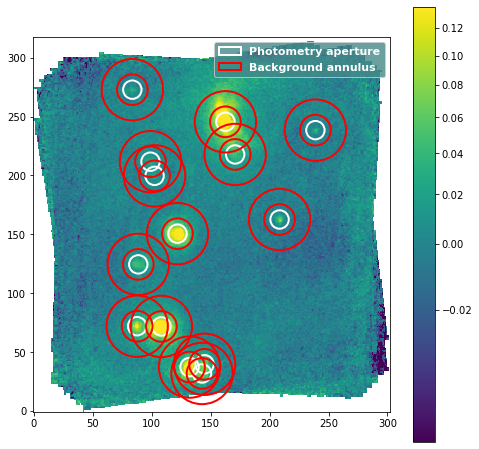

In [50]:
#now try photometry with local background subtraction
aperture2 =SkyCircularAperture(sourcecoords, r=6*u.arcsec) #define aperture
annulus_aperture_in = SkyCircularAnnulus(sourcecoords, r_in=6*u.arcsec, r_out=12*u.arcsec) #define annulus small
annulus_aperture_out = SkyCircularAnnulus(sourcecoords, r_in=10*u.arcsec, r_out=20*u.arcsec) #define annulus large

#convert to pixel coords for plotting
pix_aperture = aperture2.to_pixel(wcsmap)
pix_annulus_ap_in = annulus_aperture_in.to_pixel(wcsmap)
pix_annulus_ap_out = annulus_aperture_out.to_pixel(wcsmap)

#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)

ap_patches = pix_aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
ann_patches = pix_annulus_ap_out.plot(color='red', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

In [51]:
#now lets do robust statistics on the background annuli
appmasks_in=[]
appmasks_out=[]

#create lists to store information for later
bkg_median=[]
bkg_mean=[]
bkg_std=[]

#create mask arrays for the annuli
annulus_masks_in = pix_annulus_ap_in.to_mask(method='exact')
annulus_masks_out = pix_annulus_ap_out.to_mask(method='exact')

#for each of the annuli loop through and calculate stats using sigma cliped stats
for mask in annulus_masks_in:
    annulus_data = mask.multiply(data_bkgsub)

    maskdata=mask.data
    
    #print(np.shape(annulus_data))
    #print(np.shape(maskdata))
    #print("\n")
        
    #do statistics
    annulus_data_1d = annulus_data[maskdata > 0]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
    bkg_mean.append(meansc)
    bkg_std.append(stdsc)
    #appmasks_in.append(mask.data)

#store values in numpy arrays
bkg_median_in = np.array(bkg_median)
bkg_mean_in = np.array(bkg_mean)
bkg_std_in = np.array(bkg_std)

#create lists to store information for later
bkg_median=[]
bkg_mean=[]
bkg_std=[]

#for each of the annuli loop through and calculate stats using sigma cliped stats
for mask in annulus_masks_out:
    annulus_data = mask.multiply(data_bkgsub)
    
    maskdata=mask.data
        
    #do statistics
    annulus_data_1d = annulus_data[maskdata > 0]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
    bkg_mean.append(meansc)
    bkg_std.append(stdsc)
    #appmasks_out.append(mask.data)

#store values in numpy arrays
bkg_median_out = np.array(bkg_median)
bkg_mean_out = np.array(bkg_mean)
bkg_std_out = np.array(bkg_std)

In [52]:
#do aperture photometry
phot_table2 = aperture_photometry(data_bkgsub, aperture2,wcs=wcsmap,error=errormap,method='exact') #

#add columns for background information and also background subtracted apertures
phot_table2['annsm_bkg_med'] = bkg_median_in
phot_table2['annsm_bkg_mean'] = bkg_mean_in 
phot_table2['annlg_bkg_med'] = bkg_median_out
phot_table2['annlg_bkg_mean'] = bkg_mean_out 

#move this to later
#phot_table2['aper_sum_bkgsub_6as'] = (phot_table2['aperture_sum']/pix_aperture.area - phot_table2['ann_bkg_med'])* pix_aperture.area 
#phot_table2['aper_sum_bkgsub_err_6as'] = phot_table2['aperture_sum_err'] # should this be modified by bkgsub in some way?
#not sure if the above is right for the error array...

#calculate sky noise for 6 pixel aperture using smaller annulus
skynoise_sap=np.sqrt(phot_table2['annsm_bkg_med']*pix_aperture.area)
sna=np.array(skynoise_sap)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise_sap=sna**2

#store per pix sky noise for later
phot_table2['skynoise_pix_sm']=skynoise_sap/pix_aperture.area

#calculate sky noise for 6 pixel aperture using larger annulus
skynoise_lap=np.sqrt(phot_table2['annlg_bkg_med']*pix_aperture.area)
sna=np.array(skynoise_lap)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise_lap=sna**2

#store per pix sky noise for later
phot_table2['skynoise_pix_lg']=skynoise_lap/pix_aperture.area


#do the SNR calcs later...
#shot noise from the source
#sourcenoise=phot_table2['aper_sum_bkgsub_6as']

#thermal noise from camera (from error map)
#thermalnoise=phot_table2['aperture_sum_err']

#compute total noise 
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #all noise sources
#totalnoise=np.sqrt(thermalnoise+skynoise) # no shot noise -> For some reason this seems to give more 'reasonable' values. Need to think about why this is a bit more...
#totalnoise=np.sqrt((thermalnoise+skynoise)*(1+pix_aperture.area/pix_annulus_aperture.area)) #modified to account for pixel stats

#SNR calc for 6 pixel aperture
#phot_table2['aper_snr_6as']=phot_table2['aper_sum_bkgsub_6as']/totalnoise

#display new table
phot_table2

<ipython-input-52-6428622f4761>:16: RuntimeWarning: invalid value encountered in sqrt
  skynoise_sap=np.sqrt(phot_table2['annsm_bkg_med']*pix_aperture.area)
<ipython-input-52-6428622f4761>:26: RuntimeWarning: invalid value encountered in sqrt
  skynoise_lap=np.sqrt(phot_table2['annlg_bkg_med']*pix_aperture.area)


id,xcenter,ycenter,sky_center,aperture_sum,aperture_sum_err,annsm_bkg_med,annsm_bkg_mean,annlg_bkg_med,annlg_bkg_mean,skynoise_pix_sm,skynoise_pix_lg
,pix,pix,"deg,deg",,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64
1,88.5486546722284,124.54880261966902,"266.2814382661611,-29.177182642532923",3.7634686090971092,0.12112056940929415,0.000966738875463814,0.0019943698653745704,-0.0019911434848107496,-0.002286925084496445,0.000966738875463814,0.0
2,121.80358723546546,150.60946365376196,"266.27331265296647,-29.171623560505438",21.709318439770414,0.11869088355297192,0.0230025139500524,0.025885209361103143,0.0014042740539784188,0.0024868569306552594,0.023002513950052397,0.0014042740539784184
3,208.4163843368749,162.60885684816415,"266.25215162767114,-29.169062757110535",3.1289337638024426,0.12227119782048168,-5.0887265680721905e-05,2.7121175125386655e-05,-0.00032578203112260156,-0.0004298472362663931,0.0,0.0
4,102.37193944358717,199.63835554173696,"266.27805928055614,-29.1611638162659",1.3065011104080935,0.12206544523813265,0.00012811551973432612,0.0005321394418149863,-0.0005472593073764878,-0.0007123647909045754,0.00012811551973432612,0.0
5,98.91043936833145,211.67697382228533,"266.27890465984655,-29.158595516225645",1.6601836777791463,0.12256258096784327,8.863974058320737e-05,0.00014886429049626226,-0.00024899528522180506,-0.0003651434529746747,8.863974058320737e-05,0.0
6,238.83026331355592,238.43157934478305,"266.2447247984892,-29.152886128553426",0.8571570467365399,0.12073342976166683,-3.9724241937624565e-05,-0.00015907649135230606,-0.00042852191808236,-0.0006929946565392775,0.0,0.0
7,83.49612202734735,272.77368634555967,"266.28266846520887,-29.145561214126232",0.9544570621259776,0.15713434015685415,-0.001056293719464109,-0.0017993594609710239,-0.0007111205837697385,-0.0010329521300457497,0.0,0.0
8,132.05241134384553,37.41788201987666,"266.27080914071945,-29.195771160128547",17.03581636323402,0.16400181890806603,0.01530267352595222,0.0203561630602733,0.000152824451512985,0.0003454750546396274,0.015302673525952219,0.000152824451512985


In [53]:
#fix id keyword in tbl2 so these can be merged with the phot table results
try:
    tbl2.rename_column('label', 'id')
except:
    print('Do nothing because keyword is already changed.')

In [54]:
#merge the two photometry tables
merged_table = join(phot_table, phot_table2, keys='id')

#merge the segmentation map table with the combined phot table
merged_table_2 = join(tbl2,merged_table, keys='id')

#drop repeat columns
merged_table_2.remove_columns(['xcenter_1','ycenter_1','xcenter_2','ycenter_2','sky_center_1','sky_center_2','aperture_sum','aperture_sum_err'])

#rename some columns to avoid possible confusion
merged_table_2.rename_column('aperture_sum_0', 'aperture_sum_2as')
merged_table_2.rename_column('aperture_sum_err_0', 'aperture_sum_err_2as')
merged_table_2.rename_column('aperture_sum_1', 'aperture_sum_4as')
merged_table_2.rename_column('aperture_sum_err_1', 'aperture_sum_err_4as')
merged_table_2.rename_column('aperture_sum_2', 'aperture_sum_6as')
merged_table_2.rename_column('aperture_sum_err_2', 'aperture_sum_err_6as')
merged_table_2.rename_column('aperture_sum_3', 'aperture_sum_8as')
merged_table_2.rename_column('aperture_sum_err_3', 'aperture_sum_err_8as')
merged_table_2.rename_column('aperture_sum_4', 'aperture_sum_10as')
merged_table_2.rename_column('aperture_sum_err_4', 'aperture_sum_err_10as')


#compute area for the different size apertures 
ap2area=pix_aperture.area*(2./6.)**2
ap4area=pix_aperture.area*(4./6.)**2
ap6area=pix_aperture.area*(6./6.)**2
ap8area=pix_aperture.area*(8./6.)**2
ap10area=pix_aperture.area*(10./6.)**2


#calculate local bkg subtracted photometry for the other apertures 
merged_table_2['aper_sum_bkgsub_2as']=(merged_table_2['aperture_sum_2as']/ap2area-merged_table_2['annsm_bkg_med'])*ap2area
merged_table_2['aper_sum_bkgsub_4as']=(merged_table_2['aperture_sum_4as']/ap4area-merged_table_2['annsm_bkg_med'])*ap4area
merged_table_2['aper_sum_bkgsub_6as']=(merged_table_2['aperture_sum_6as']/ap6area-merged_table_2['annlg_bkg_med'])*ap6area
merged_table_2['aper_sum_bkgsub_8as']=(merged_table_2['aperture_sum_8as']/ap8area-merged_table_2['annlg_bkg_med'])*ap8area
merged_table_2['aper_sum_bkgsub_10as']=(merged_table_2['aperture_sum_10as']/ap10area-merged_table_2['annlg_bkg_med'])*ap10area

#calculate snr for each aperture
merged_table_2['aper_snr_2as']=merged_table_2['aper_sum_bkgsub_2as']/np.sqrt((merged_table_2['aperture_sum_err_2as']+merged_table_2['skynoise_pix_sm']*ap2area)*(1+ap2area/pix_annulus_ap_in.area))
merged_table_2['aper_snr_4as']=merged_table_2['aper_sum_bkgsub_4as']/np.sqrt((merged_table_2['aperture_sum_err_4as']+merged_table_2['skynoise_pix_sm']*ap4area)*(1+ap4area/pix_annulus_ap_in.area))
merged_table_2['aper_snr_6as']=merged_table_2['aper_sum_bkgsub_6as']/np.sqrt((merged_table_2['aperture_sum_err_6as']+merged_table_2['skynoise_pix_lg']*ap6area)*(1+ap6area/pix_annulus_ap_out.area))
merged_table_2['aper_snr_8as']=merged_table_2['aper_sum_bkgsub_8as']/np.sqrt((merged_table_2['aperture_sum_err_8as']+merged_table_2['skynoise_pix_lg']*ap8area)*(1+ap8area/pix_annulus_ap_out.area))
merged_table_2['aper_snr_10as']=merged_table_2['aper_sum_bkgsub_10as']/np.sqrt((merged_table_2['aperture_sum_err_10as']+merged_table_2['skynoise_pix_lg']*ap10area)*(1+ap10area/pix_annulus_ap_out.area))

#calculate max snr for all apertures
snr_values=np.array(merged_table_2['aper_snr_2as','aper_snr_4as','aper_snr_6as','aper_snr_8as','aper_snr_10as'])
snr_values.dtype=np.float
snr_values=np.reshape(snr_values, (-1,5))
maxsnr=np.nanmax(snr_values,axis=1)
merged_table_2['aper_snr_max']=maxsnr

#add additonal information for wavelength and which field 
merged_table_2['Field']='C7'+field
merged_table_2['wv']=wavelength

#display table
merged_table_2

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,annsm_bkg_med,annsm_bkg_mean,annlg_bkg_med,annlg_bkg_mean,skynoise_pix_sm,skynoise_pix_lg,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_6as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_6as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,88.5486546722902,124.5488026197025,"266.2814382661611,-29.177182642532923",-0.0012460201479262095,0.005647129226364597,0.3727105289400634,66.0,2.7028742483211388,1.8256747370549247,-13.919346976883787,0.14632302869659877,0.07618349422001398,0.29058165388252366,0.7373995783038069,0.32454321980057976,1.4804796240327358,5.431069025143904,5.3946689812313915,0.22905704564657148,2.6614300055116678,2.1114772193430844,0.07105882,0.005673804110468762,0.005903587798025578,0.0007215142624711953,3.110852089658853,0.7729657256885045,0.0403774134961474,2.442625106161037,0.08075334126078458,3.7634686090971092,0.12112056940929415,4.870470967408658,0.16147946679505468,5.578781478807223,0.20182530884484423,0.000966738875463814,0.0019943698653745704,-0.0019911434848107496,-0.002286925084496445,0.000966738875463814,0.0,0.7523690751933962,2.3602385041806033,4.145265583800594,5.549221144659296,6.639328630761346,2.9919975366853566,5.453518274216997,11.254712290626205,12.536702343635183,12.798733158639443,12.798733158639443,C7Field5,25.2
2,121.80358723541922,150.60946365378916,"266.27331265296647,-29.171623560505438",-0.0043280873083988945,0.008450474316964635,4.081579095093918,483.0,5.500199645140461,4.922875172076749,-35.90671821250241,0.03587843871741396,0.007797682875238806,0.03844016025006406,0.4459944535381313,0.10496427590111035,1.117273839551809,12.291043634546321,40.963367058398504,0.2728794214766754,1.3799994379097387,35.05927320908158,0.1883232,0.007854968374175219,0.008156032935515733,0.0015791576411173824,17.256373189343893,3.6843206721714594,0.039617466370625236,12.490208894739858,0.07915768514437317,21.709318439770414,0.11869088355297192,30.115635761990724,0.15825857976935212,36.13817769772563,0.1978389862394948,0.0230025139500524,0.025885209361103143,0.0014042740539784188,0.0024868569306552594,0.023002513950052397,0.0014042740539784184,3.1942454798287696,10.529908125369097,21.440052267064374,29.636940343846653,35.39021610687552,4.309820458274286,6.881263458166779,32.52557633482367,33.71236866562366,31.514763981672626,33.71236866562366,C7Field5,25.2
3,208.41638433682664,162.60885684816262,"266.25215162767114,-29.169062757110535",0.010113798393226466,-0.004911119064399497,-0.2995782629283693,61.0,2.027186288050507,1.7338568088947073,84.89451948035084,0.3319321112455416,-0.015830436406072197,0.24404671605582415,0.5181295366843096,0.14469784098524419,1.169177453207794,4.441737349067447,3.272148660070302,0.13910873990982683,1.896308157696814,2.3447741144033696,0.06896897,-0.004989864398964471,-0.004977315504660779,0.0007081644055886727,8.928410542127502,1.2874599594426586,0.04075537107390001,2.5509230908235527,0.08151695762897952,3.

In [55]:
#write out the resulting table to file
ascii.write(merged_table_2, field+'_25um_cat.dat', overwrite=True)

In [61]:
#add simple quality cuts to saved sources
snrcut=merged_table_2['aper_snr_max']>=3.0 #max snr in all computed apertures must be gtreq to 3.0
#fwhmcut=merged_table_2['fwhm']>=2.5*u.pix #fwhm measures must be greater than 2.5 pixels (~1.9")
#keepconditions=(snrcut&fwhmcut) #conditions to keep a source
#mtcut=merged_table_2[keepconditions] #apply conditions
mtcut=merged_table_2[snrcut] #apply only snr cut

#display new table with simple quality cuts
mtcut

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,annsm_bkg_med,annsm_bkg_mean,annlg_bkg_med,annlg_bkg_mean,skynoise_pix_sm,skynoise_pix_lg,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_6as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_6as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,88.5486546722902,124.5488026197025,"266.2814382661611,-29.177182642532923",-0.0012460201479262095,0.005647129226364597,0.3727105289400634,66.0,2.7028742483211388,1.8256747370549247,-13.919346976883787,0.14632302869659877,0.07618349422001398,0.29058165388252366,0.7373995783038069,0.32454321980057976,1.4804796240327358,5.431069025143904,5.3946689812313915,0.22905704564657148,2.6614300055116678,2.1114772193430844,0.07105882,0.005673804110468762,0.005903587798025578,0.0007215142624711953,3.110852089658853,0.7729657256885045,0.0403774134961474,2.442625106161037,0.08075334126078458,3.7634686090971092,0.12112056940929415,4.870470967408658,0.16147946679505468,5.578781478807223,0.20182530884484423,0.000966738875463814,0.0019943698653745704,-0.0019911434848107496,-0.002286925084496445,0.000966738875463814,0.0,0.7523690751933962,2.3602385041806033,4.145265583800594,5.549221144659296,6.639328630761346,2.9919975366853566,5.453518274216997,11.254712290626205,12.536702343635183,12.798733158639443,12.798733158639443,C7Field5,25.2
2,121.80358723541922,150.60946365378916,"266.27331265296647,-29.171623560505438",-0.0043280873083988945,0.008450474316964635,4.081579095093918,483.0,5.500199645140461,4.922875172076749,-35.90671821250241,0.03587843871741396,0.007797682875238806,0.03844016025006406,0.4459944535381313,0.10496427590111035,1.117273839551809,12.291043634546321,40.963367058398504,0.2728794214766754,1.3799994379097387,35.05927320908158,0.1883232,0.007854968374175219,0.008156032935515733,0.0015791576411173824,17.256373189343893,3.6843206721714594,0.039617466370625236,12.490208894739858,0.07915768514437317,21.709318439770414,0.11869088355297192,30.115635761990724,0.15825857976935212,36.13817769772563,0.1978389862394948,0.0230025139500524,0.025885209361103143,0.0014042740539784188,0.0024868569306552594,0.023002513950052397,0.0014042740539784184,3.1942454798287696,10.529908125369097,21.440052267064374,29.636940343846653,35.39021610687552,4.309820458274286,6.881263458166779,32.52557633482367,33.71236866562366,31.514763981672626,33.71236866562366,C7Field5,25.2
3,208.41638433682664,162.60885684816262,"266.25215162767114,-29.169062757110535",0.010113798393226466,-0.004911119064399497,-0.2995782629283693,61.0,2.027186288050507,1.7338568088947073,84.89451948035084,0.3319321112455416,-0.015830436406072197,0.24404671605582415,0.5181295366843096,0.14469784098524419,1.169177453207794,4.441737349067447,3.272148660070302,0.13910873990982683,1.896308157696814,2.3447741144033696,0.06896897,-0.004989864398964471,-0.004977315504660779,0.0007081644055886727,8.928410542127502,1.2874599594426586,0.04075537107390001,2.5509230908235527,0.08151695762897952,3.

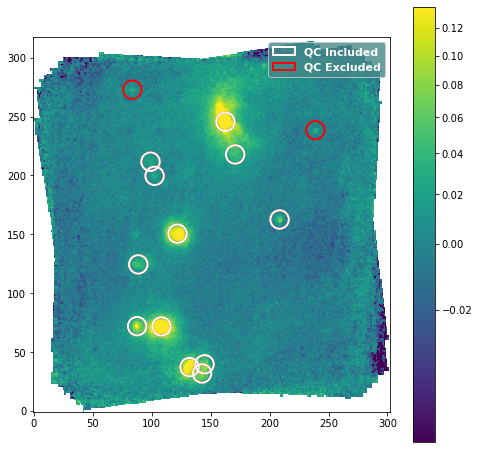

In [62]:
#now let's examine which sources didn't pass the cuts - overplot on the image to see if it looks first order reasonable

#get source coordinates for the snr cut table
cutsc=mtcut['sky_centroid'] 

#Compare which sources are included/excluded
source_aperture =SkyCircularAperture(cutsc, r=6*u.arcsec)

#convert to pixel coords for plotting
pix_aperture_source = source_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)


ap_patches = pix_aperture.plot(color='red', lw=2,
                           label='QC Excluded')
ap_patches_new = pix_aperture_source.plot(color='white', lw=2,
                           label='QC Included')

handles = (ap_patches_new[0],ap_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
          handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

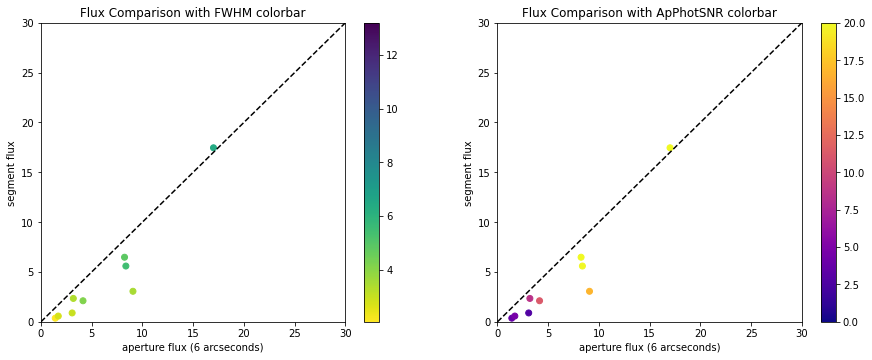

In [58]:
#a few diagnostic plots to examine segment and aperture fluxes
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with FWHM colorbar')
p1=ax1.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['fwhm']*0.768, cmap='viridis_r')
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (6 arcseconds)')
ax1.set_ylabel('segment flux')
ax1.set_xlim(0,30)
ax1.set_ylim(0,30)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=20)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (6 arcseconds)')
ax2.set_ylabel('segment flux')
ax2.set_xlim(0,30)
ax2.set_ylim(0,30)


plt.show()

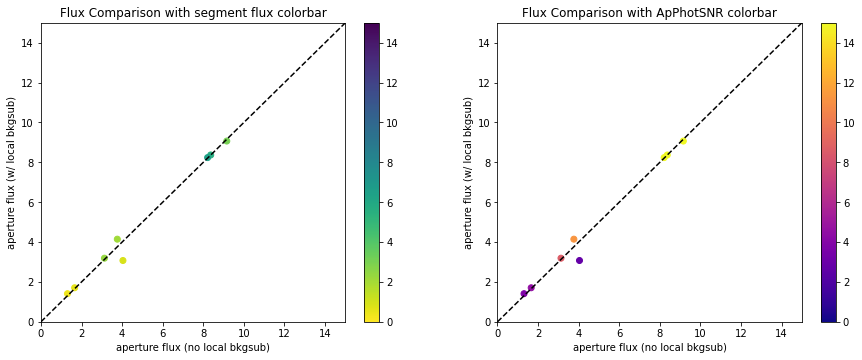

In [59]:
#a few diagnostic plots to examine background contributions to aperture flux
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with segment flux colorbar')
p1=ax1.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['segment_flux'], cmap='viridis_r',vmin=0,vmax=15)
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (no local bkgsub)')
ax1.set_ylabel('aperture flux (w/ local bkgsub)')
ax1.set_xlim(0,15)
ax1.set_ylim(0,15)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=15)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (no local bkgsub)')
ax2.set_ylabel('aperture flux (w/ local bkgsub)')
ax2.set_xlim(0,15)
ax2.set_ylim(0,15)


plt.show()

In [60]:
#write out the resulting table to file
ascii.write(mtcut, field+'_25um_cat_qcuts.dat', overwrite=True)